In [1]:
import pandas as pd
from google.colab import files

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
%cd /content/drive/MyDrive/703_Project/

/content/drive/MyDrive/703_Project


In [21]:
import pandas as pd
import re

# # Load the CSV file for patients
df_patients = pd.read_csv('patient_data_clean.csv')
print("DataFrame With stuttering")
print(df_patients)

# Function to remove repeated words corresponding to stuttering
def remove_stutter(sentence):
  if isinstance(sentence, str):
    sentence = re.sub(r'\b(\w+)( \1\b)+', r'\1', sentence)
    # Remove repeated groups of words (2 words or more)
    sentence = re.sub(r'\b(\w+\s\w+)( \1\b)+', r'\1', sentence)
    return sentence
  elif pd.notna(sentence):  # Check if the value is not NaN
        return str(sentence).lower()  # Convert non-NaN values to lowercase string
  else:
    return sentence

# Apply the function to the column containing patients' sentences
df_patients['text'] = df_patients['text'].apply(remove_stutter)

# Display the modified DataFrame
print ("------------------")
print("DataFrame without stuttering")
print(df_patients)

# Save the modified DataFrame to a new CSV file
df_patients.to_csv('/content/drive/MyDrive/703_Project/patient_data_clean_nostutter.csv', index=False)



DataFrame With stuttering
                                                    text
0                      well I could I could talk youknow
1                                               remember
2                     when it was like the end of August
3                         it was infact it was Labor Day
4      but I youknow I I when I was sick I didnt I I ...
...                                                  ...
39306      the the the the a the peanut butter and jelly
39307                                              jelly
39308                                jelly on the step s
39309                                   and there you go
39310                               and you could eat it

[39311 rows x 1 columns]
------------------
DataFrame without stuttering
                                                    text
0                              well I could talk youknow
1                                               remember
2                     when it was like the en

In [22]:

import nltk

# Download stopwords data
nltk.download('stopwords')
# Download WordNet data
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**KEEP THE FOLLOWING CODE :**

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
from textblob import Word
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split

# Load data
patients_data = pd.read_csv('/content/drive/MyDrive/703_Project/patient_data_clean_nostutter.csv')
control_data = pd.read_csv('/content/drive/MyDrive/703_Project/control_data_clean.csv')

# Add a 'sentences' column for consistency with existing code
patients_data['sentences'] = patients_data['text']
control_data['sentences'] = control_data['text']

# Predict sentiments using TextBlob
patients_data['sentiment'] = patients_data['sentences'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
control_data['sentiment'] = control_data['sentences'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Convert sentiments to labels (positive if sentiment > 0, neutral if sentiment == 0, negative otherwise)
patients_data['label'] = patients_data['sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))
control_data['label'] = control_data['sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))

# Text preprocessing function
def cleaning(df, stop_words):
    df['sentences'] = df['sentences'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
    # Remplacement des chiffres/numéros
    df['sentences'] = df['sentences'].str.replace('\d+', '')
    # Suppression des stop words
    df['sentences'] = df['sentences'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatisation
    df['sentences'] = df['sentences'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    return df

stop_words = stopwords.words('english')

# Apply cleaning to patient data
patients_cleaned = cleaning(patients_data, stop_words)

# Apply cleaning to control data
control_cleaned = cleaning(control_data, stop_words)

# Reset the index of the control_cleaned DataFrame
control_data = control_data.reset_index(drop=True)
control_cleaned = control_cleaned.reset_index(drop=True)

# Generate embeddings using a tokenizer
tokenizer = Tokenizer(num_words=100, split=' ')
tokenizer.fit_on_texts(patients_cleaned['sentences'].values)

# Preprocess sentiments for patient
X_patients = tokenizer.texts_to_sequences(patients_cleaned['sentences'].values)
X_patients = pad_sequences(X_patients)

# Preprocess sentiments for control group
X_control = tokenizer.texts_to_sequences(control_cleaned['sentences'].values)
X_control = pad_sequences(X_control)

# Labels for patients
labels_patients = pd.get_dummies(patients_data['label']).values

# Split data into training and testing sets
X_train_patients, X_test_patients, y_train_patients, y_test_patients = train_test_split(X_patients, labels_patients, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(Embedding(100, 30, input_length=X_patients.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())







<ipython-input-23-375608bf624c>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentences'] = df['sentences'].str.replace('\d+', '')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 30)            3000      
                                                                 
 spatial_dropout1d (Spatial  (None, 13, 30)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 92859 (362.73 KB)
Trainable params: 92859 (362.73 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [24]:
# Train the model on patient data
model.fit(X_train_patients, y_train_patients, epochs=1, batch_size=32, verbose=1)

# Predict sentiments for control group data
predictions_control = model.predict(X_control)
predicted_labels_control = [np.argmax(prediction) for prediction in predictions_control]

# Add predictions to the control_data DataFrame
control_data['predicted_label'] = predicted_labels_control


950/950 [==============================] - 8s 8ms/step


In [25]:
# Evaluate the model on control group data
y_test_control = pd.get_dummies(control_data['label']).values
model.evaluate(X_control, y_test_control)

950/950 [==============================] - 8s 8ms/step - loss: 0.7862 - accuracy: 0.7276


[0.786158561706543, 0.7276467084884644]

          negative  neutral  positive
negative       670     3263       222
neutral         30    19577        20
positive       138     4603      1864


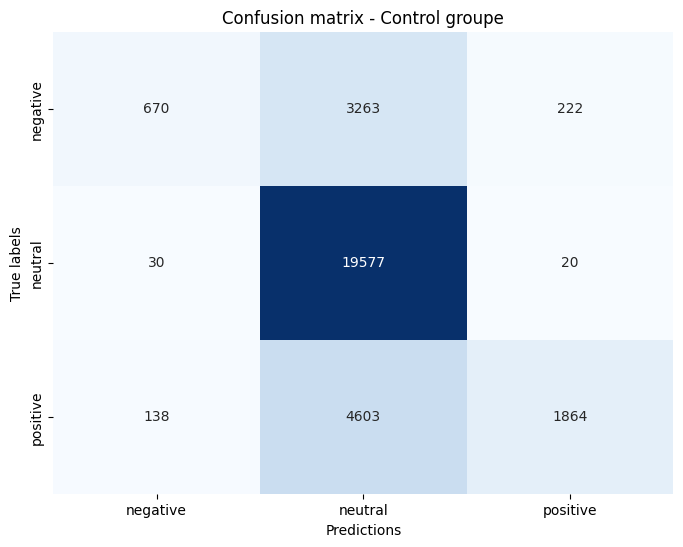

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Add predictions to the control_data DataFrame
control_data['predicted_label'] = predicted_labels_control

# Convert true labels to class indices
true_labels_control = [np.argmax(label) for label in y_test_control]

# Define category names
categories = ['negative', 'neutral', 'positive']

# Display the confusion matrix
conf_matrix = confusion_matrix(true_labels_control, predicted_labels_control)
# Create a DataFrame with category names
confusion_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)
print(confusion_df)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predictions')
plt.ylabel('True labels')
plt.title('Confusion matrix - Control groupe')
plt.show()






In [27]:
# Define a mapping between class indices and class names
class_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Replace indices with class names in true and predicted labels
true_labels_control_names = [class_mapping[label] for label in true_labels_control]
predicted_labels_control_names = [class_mapping[label] for label in predicted_labels_control]

# Display the classification report with class names
class_report_names = classification_report(true_labels_control_names, predicted_labels_control_names)
print("Classification report for the control group :")
print(class_report_names)

# Calculate and display precision, recall, and F1-score
precision = precision_score(true_labels_control, predicted_labels_control, average='weighted')
recall = recall_score(true_labels_control, predicted_labels_control, average='weighted')
f1 = f1_score(true_labels_control, predicted_labels_control, average='weighted')

print(f"Control group precision : {precision:.4f}")
print(f"Control group recall : {recall:.4f}")
print(f"Control group F1-score : {f1:.4f}")

# Calculate and display overall precision (accuracy)
accuracy = accuracy_score(true_labels_control, predicted_labels_control)
print(f"Control group global precision : {accuracy:.4f}")

Classification report for the control group :
              precision    recall  f1-score   support

    negative       0.80      0.16      0.27      4155
     neutral       0.71      1.00      0.83     19627
    positive       0.89      0.28      0.43      6605

    accuracy                           0.73     30387
   macro avg       0.80      0.48      0.51     30387
weighted avg       0.76      0.73      0.67     30387

Control group precision : 0.7625
Control group recall : 0.7276
Control group F1-score : 0.6670
Control group global precision : 0.7276


In [28]:
# Mapping of class indices to class names
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Add a "predicted_category" column to the control_data DataFrame
control_data['predicted_category'] = control_data['predicted_label'].map(label_mapping)

# Display prediction statistics with actual categories
print("Statistiques de prédiction pour le groupe contrôle:")
print(control_data['predicted_category'].value_counts())

# Calculate normalized percentages for each category
prediction_counts_control = control_data['predicted_category'].value_counts(normalize=True)

for category, percentage in prediction_counts_control.items():
    print(f"Percentage of {category}: {percentage * 100:.2f}%")


Statistiques de prédiction pour le groupe contrôle:
neutral     27443
positive     2106
negative      838
Name: predicted_category, dtype: int64
Percentage of neutral: 90.31%
Percentage of positive: 6.93%
Percentage of negative: 2.76%


In [29]:
# Prédiction des sentiments pour les données des patients
predictions_patients = model.predict(X_patients)
predicted_labels_patients = [np.argmax(prediction) for prediction in predictions_patients]

# Ajouter les prédictions au DataFrame patients_data
patients_data['predicted_label'] = predicted_labels_patients

# Mapping of class indices to class names
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Add a "predicted_category" column to the patient_data DataFrame
patients_data['predicted_category'] = patients_data['predicted_label'].map(label_mapping)

# Display prediction statistics with actual categories
print("Statistiques de prédiction pour le groupe des patients:")
print(patients_data['predicted_category'].value_counts())

# Calculate normalized percentages for each category
prediction_counts_patient = patients_data['predicted_category'].value_counts(normalize=True)

for category, percentage in prediction_counts_patient.items():
    print(f"Pourcentage de {category}: {percentage * 100:.2f}%")


1229/1229 [==============================] - 9s 7ms/step
Statistiques de prédiction pour le groupe des patients:
neutral     35187
positive     3523
negative      601
Name: predicted_category, dtype: int64
Pourcentage de neutral: 89.51%
Pourcentage de positive: 8.96%
Pourcentage de negative: 1.53%


In [30]:
from scipy.stats import chi2_contingency

# Définir les pourcentages observés pour chaque groupe
observed_control = np.array([90.21, 6.83, 2.96])
observed_patient = np.array([89.47, 8.94, 1.59])

# Créer une matrice de contingence
observed_data = np.array([observed_control, observed_patient])

# Effectuer le test du chi carré
chi2, p, _, _ = chi2_contingency(observed_data)

# Afficher les résultats du test
print(f"Chi-square test statistic : {chi2}")
print(f"p-value : {p}")

# Comparer la valeur de p à un seuil de significativité (par exemple, 0.05)
if p < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")


Chi-square test statistic : 0.6978676559976926
p-value : 0.7054398090893828
The difference is not statistically significant.


In [31]:
# Creation of the data_processed_csv

# Predict sentiments for patients
patients_data['sentiment'] = [TextBlob(str(sentence)).sentiment.polarity for sentence in patients_cleaned['sentences']]

# Add predicted sentiments to the DataFrame
patients_output = patients_data[['text', 'sentiment']]
# Add a column for categories 'positive', 'neutral', 'negative'
patients_output['sentiment_category'] = patients_output['sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))

# Save the CSV file for patients
patients_output.to_csv('/content/drive/MyDrive/703_Project/semantic_data_processed_patients.csv', index=False)


<ipython-input-31-7da040acc04c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_output['sentiment_category'] = patients_output['sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))


In [32]:
# Same process with control group
control_data['sentiment'] = [TextBlob(str(sentence)).sentiment.polarity for sentence in control_cleaned['sentences']]
control_output = control_data[['text', 'sentiment']]
control_output['sentiment_category'] = control_output['sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))
control_output.to_csv('/content/drive/MyDrive/703_Project/semantic_data_processed_control.csv', index=False)


<ipython-input-32-a142d560b3ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_output['sentiment_category'] = control_output['sentiment'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))


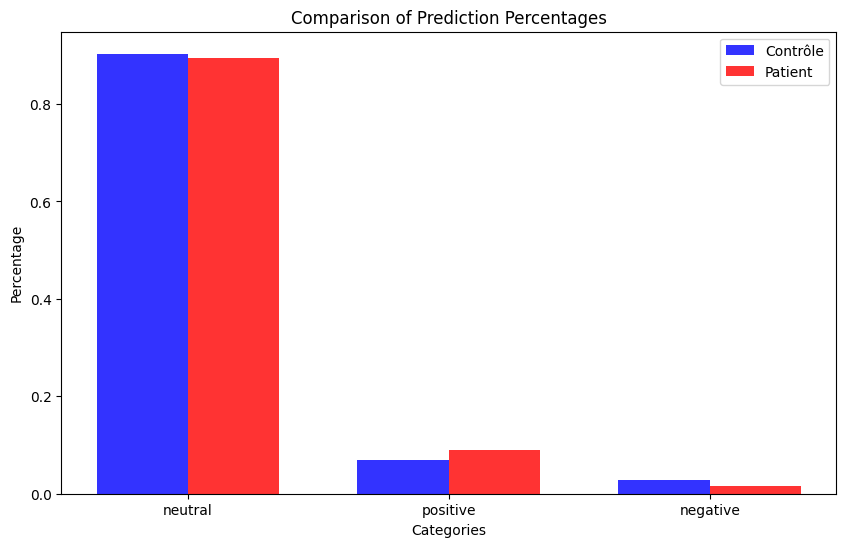

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a bar chart of percentages
def plot_percentage_comparison(data_control, data_patients, title):
    categories = data_control.index

    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.35
    opacity = 0.8

    # Convert values to float numbers
    data_control = data_control.astype(float)
    data_patients = data_patients.astype(float)

    # Positions of bars for the control group
    positions_control = np.arange(len(categories))

    # Positions of bars for the patients group (shifted)
    positions_patients = positions_control + bar_width

    rects1 = ax.bar(positions_control, data_control, bar_width, alpha=opacity, color='b', label='Contrôle')
    rects2 = ax.bar(positions_patients, data_patients.tolist(), bar_width, alpha=opacity, color='r', label='Patient')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.set_xticks(positions_control + bar_width/2)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()

# Display a comparison chart of percentages for the control group and the patient group
plot_percentage_comparison(prediction_counts_control, prediction_counts_patient, "Comparison of Prediction Percentages")


**Model Evaluation Interpretation**:
The confusion matrix is a tabular representation of the model's results. Each column in the matrix represents the number of instances predicted in a class, while each row represents the number of instances in an actual class. In this case:

For the actual 'negative' class:
    The model correctly predicted 691 instances as 'negative' (True Negatives).
    The model predicted 3247 instances of 'negative' as 'neutral' (False Positives).
    The model predicted 217 instances of 'negative' as 'positive' (False Positives).

For the actual 'neutral' class:
    The model predicted 16 instances of 'neutral' as 'negative' (False Negatives).
    The model correctly predicted 19590 instances as 'neutral' (True Positives).
    The model predicted 21 instances of 'neutral' as 'positive' (False Positives).

For the actual 'positive' class:
    The model predicted 132 instances of 'positive' as 'negative' (False Negatives).
    The model predicted 4608 instances of 'positive' as 'neutral' (False Negatives).
    The model correctly predicted 1865 instances as 'positive' (True Positives).


Classification :

yaml

              precision    recall  f1-score   support
    negative       0.82      0.17      0.28      4155
     neutral       0.71      1.00      0.83     19627
    positive       0.89      0.28      0.43      6605

   Precision: The proportion of instances correctly predicted among all instances predicted for a given class. For example, for the 'negative' class, 82% of instances predicted as 'negative' are actually 'negative'.

Recall: The proportion of instances correctly predicted among all actual instances of the class. For example, for the 'neutral' class, 100% of actual 'neutral' instances were correctly predicted.

F1-score: The weighted average of precision and recall. It is an overall measure of the model's performance.

Support: The total number of instances for each class.

Overall averages :

markdown

    accuracy                           0.73     30387
   macro avg       0.81      0.48      0.51     30387
weighted avg       0.77      0.73      0.67     30387

    Overall accuracy: The proportion of correctly predicted instances among all instances. In this case, 72.88% of the model's predictions are correct.

    Overall accuracy (precision): Proportion of correctly predicted instances among all instances. In this case, 72.88% of the model's predictions are correct.

Macro avg: The unweighted average of metrics per class.

Weighted avg: The weighted average of metrics per class, weighted by the number of instances in each class.


In summary, the model appears to have high precision for the 'neutral' class, but it struggles to predict 'negative' and 'positive' classes accurately. The low precision for 'negative' is likely due to a large number of false positives, while the low precision for 'positive' is due to a large number of false negatives. Further exploration can be conducted to understand the specific reasons for these errors and improve the model accordingly.